In [1]:
import matplotlib.pyplot as plt
import numpy as np

import magnify as mg

# MRBLES Magnify Processing Tutorial
We'll consider three different experiments. A single image, a tiled image, and a tiled image that's not 2x2 binned.

## Single Image
Let's consider the simplest case where we only have a non-tiled image. Here we have a single image with 10 codes: 1, 11, 21, 41, 22, 23, 24, 25, 27, 28.
This image was acquired without 2x2 binning, so a single pixel is 1.61 um.
Let's process the image with magnify.

In [2]:
# Setup the pipeline. You should rarely need to modify these values outside of `num_codes`
# unless you're switching between different image binning modes (since that changes the pixel sizes).
pipe = mg.mrbles(  # The type of experiment we're processing, in this case mrbles.
    darkfield="data/darkfield.tiff",  # The location of the darkfield correction image.
    flatfield="data/flatfield.tiff",  # The location of the flatfield correction image.
    min_bead_radius=10,  # The minimum radius of beads in pixels.
    max_bead_radius=50,  # The maximum radius of beads in pixels.
    spectra="data/refs.csv",  # A csv file of the reference spectra for each lanthanide.
    codes="data/codes2.csv",  # A csv file of the bead codes and their lanthanide ratios.
    search_channel="620",  # Which channel to use for bead finding.
)
# Process the experiment.
xp = pipe("data/xp1.ome.tif")
# Get a list of each unique code name.
tags = np.unique(xp.tag.to_numpy())

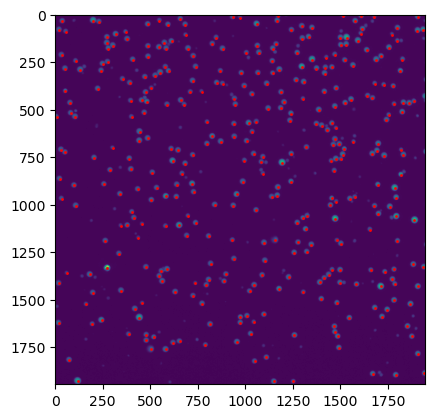

In [3]:
# Now let's check the image corresponding to the 620 channel to make sure magnify correctly processed our experiment.
# First display the image.
plt.imshow(xp.image.sel(channel="620"))

# Then draw the position of the found beads above it.
plt.scatter(xp.x, xp.y, s=1.0, color="r")
# We can see that we found most beads and ignored beads below the cuttoff radius.

In [4]:
# We can also count the beads that we found pretty easily.
print(f"Found {len(xp.mark)} beads.")

Found 369 beads.


Text(0, 0.5, 'Sm Ratio')

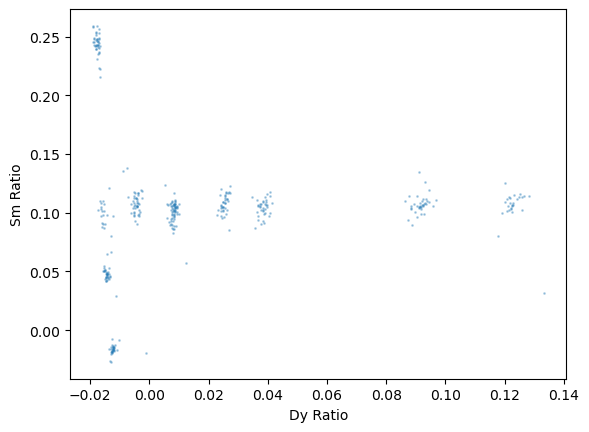

In [5]:
# We can also visualize the lanthanide ratios for each bead. We see here that we get distinct clusters.
plt.scatter(xp.ln_ratio.sel(ln="dy"), xp.ln_ratio.sel(ln="sm"), s=1.0, alpha=0.3)
plt.xlabel("Dy Ratio")
plt.ylabel("Sm Ratio")

We can check to see if our pipeline correctly clustered the beads based on their ratios.
The clustering algorithm in magnify is still imperfect so it's important to check this!

You'll notice we're using `where` to subselect data which you can read about [here](https://docs.xarray.dev/en/stable/user-guide/indexing.html#masking-with-where).

Text(0, 0.5, 'Sm Ratio')

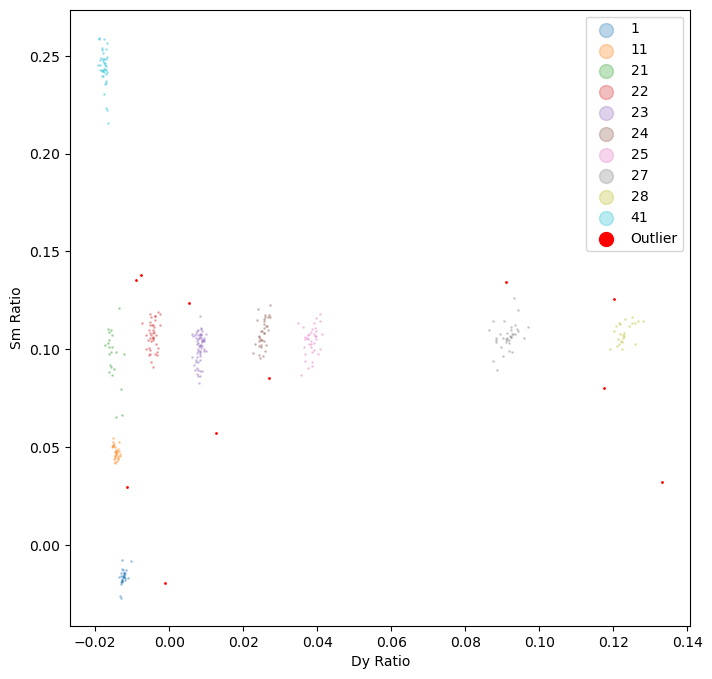

In [6]:
plt.figure(figsize=(8, 8))
# Iterate over all 10 codes + the cluster assigned to outlier points.
for tag in tags:
    # Only consider the points assigned to the current cluster.
    ln_ratio = xp.ln_ratio.where(xp.tag == tag, drop=True)
    if tag == "outlier":
        # Color the outlier cluster so it stands out.
        plt.scatter(
            ln_ratio.sel(ln="dy"),
            ln_ratio.sel(ln="sm"),
            color="r",
            s=1.0,
            alpha=1.0,
            label="Outlier",
        )
    else:
        plt.scatter(ln_ratio.sel(ln="dy"), ln_ratio.sel(ln="sm"), s=1.0, alpha=0.3, label=tag)
# Add the legend with large markers.
plt.legend(markerscale=10)
plt.xlabel("Dy Ratio")
plt.ylabel("Sm Ratio")

We can also count beads based on which cluster they were assigned to.

In [7]:
# Iterate over all 10 codes + the cluster assigned to outlier points.
for tag in tags:
    # Only consider the points assigned to the current cluster.
    mark = xp.mark.where(xp.tag == tag, drop=True)
    if tag == "outlier":
        print(f"There are {len(mark)} outliers.")
    else:
        print(f"Cluster {tag} has {len(mark)} beads assigned to it.")

Cluster 1 has 29 beads assigned to it.
Cluster 11 has 30 beads assigned to it.
Cluster 21 has 22 beads assigned to it.
Cluster 22 has 41 beads assigned to it.
Cluster 23 has 63 beads assigned to it.
Cluster 24 has 36 beads assigned to it.
Cluster 25 has 37 beads assigned to it.
Cluster 27 has 36 beads assigned to it.
Cluster 28 has 24 beads assigned to it.
Cluster 41 has 40 beads assigned to it.
There are 11 outliers.


## Tiled Image
Now let's consider a tiled image. This image consists of codes that were missing in a prior experiment.
This image was acquired with 2x2 binning, so a single pixel is now 3.22 um.

We can then process the image with magnify and then use `xp` exactly as we did above.

In [8]:
# Setup the pipeline. Here we needed to change darkfield, flatfield, min_bead_radius, and max_bead_radius to account for the 2x2 binning.
pipe = mg.mrbles(
    darkfield="data/darkfield2x2.tiff",
    flatfield="data/flatfield2x2.tiff",
    min_bead_radius=5,
    max_bead_radius=25,
    spectra="data/refs.csv",
    codes="data/codes.csv",
    search_channel="620",
)
# The filepath supports globs (https://en.wikipedia.org/wiki/Glob_(programming)) so * expands to match anything that matches the pattern.
# (row), (col) are equivalent to * but they also save the segment of the filename they match in the resulting experiment.
# In this case we're telling the pipeline that the filename specified the tile column and row.
xp = pipe("data/06.08.23 1-50 mix/mixed all tile 2b2_2/*Pos(col)_(row).ome.tif")